In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DEFINING THE PATH WHICH CONTAINS ALL THE IMAGES

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data_dir='/content/drive/MyDrive/WASTE_DATASET'

DETERMINE THE COUNTS FOR ALL THE IMAGES

In [ ]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)
train=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode='rgb',
    batch_size=16,
    subset="training",
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.2,
)

Found 4776 files belonging to 9 classes.
Using 3821 files for training.


RESIZING ALL THE IMAGES INTO 224,224 AND DEFIINING NUMBER OF CLASSES INTO WHICH THE DATA NEEDS TO BE CLASSIFIED INTO

In [ ]:
img_height, img_width = 224,224
num_classes = 9
batch_size = 32

USING DATA AUGMENTATION TO GENERATE MORE IMAGES AS WELL AS TO IMPORTANT . DATA AUGMENTATION ACTS AS A FORM OF REGULARIZATION BY ADDING NOISE TO THE TRAINING DATA. BY EXPOSING THE MODEL TO SLIGHTLY PERTURBED VERSIONS OF THE INPUT DATA DURING TRAINING, IT CAN HELP PREVENT OVERFITTING AND IMPROVE THE GENERALIZATION ABILITY OF THE MODEL.

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.5,
#     zoom_range=0.5,
#     horizontal_flip=True,
#     validation_split=0.2)


# test_datagen=ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
#  )

# train_generator = train_datagen.flow_from_directory(
#     data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='training')

# validation_generator = test_datagen.flow_from_directory(
#     data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='validation')


In [ ]:
test=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode='rgb',
    batch_size=16,
    subset="validation",
    image_size=(224, 224),
    seed=123,
    shuffle=True,
    validation_split=0.2,
)

Found 4776 files belonging to 9 classes.
Using 955 files for validation.


In [ ]:
# import matplotlib.pyplot as plt

# # Get the first batch of images and labels from the validation generator
# images, labels = validation_generator.next()

# # Display the first image and its label
# plt.imshow(images[0])
# plt.title('Label: {}'.format(labels[16]))
# plt.axis('off')
# plt.show()


In [ ]:
# import numpy as np

# # Predict the class probabilities for the first batch of images
# class_probabilities = model.predict(images)

# # Use argmax to get the predicted class label
# predicted_classes = np.argmax(class_probabilities, axis=1)

# # Display the predicted class label
# print("Predicted class label for the first image:", predicted_classes[16])


In [ ]:
# import numpy as np

# # Predict the class probabilities for the first batch of images
# class_probabilities = model.predict(images)

# # Convert one-hot encoded labels to class indices
# true_classes = np.argmax(labels, axis=0)

# # Use argmax to get the predicted class label
# predicted_classes = np.argmax(class_probabilities, axis=1)

# # Display the true class label and the predicted class label for the first image
# print("True class label for the first image:", true_classes[0])
# print("Predicted class label for the first image:", predicted_classes[0])


# TRANSFER LEARNING USING DENSENET 121.


In [ ]:
from keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print("Number of layers in the base model: ", len(base_model.layers))

29084464/29084464 [==============================] - 0s 0us/step
Number of layers in the base model:  427


TAKING A SUMMARY OF THE MODEL TO UNDESTAND NUMBER OF LAYERS AND THE TOTAL NUMBER OF PARAMETERS

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

LOOKING AT SOME OF THE DATA AUGMENTED IMAGES TO UNDERSTAND WHAT ALL CHANGES HAVE BEEN MADE IN THE ORIGINAL PICTURE

In [ ]:
# import matplotlib.pyplot as plt

# def plotImages(original_images, augmented_images):
#     fig, axes = plt.subplots(2, 5, figsize=(20, 10))
#     axes = axes.flatten()

#     # Plot original images
#     for img, ax in zip(original_images, axes[:5]):
#         ax.imshow(img)
#         ax.axis('off')
#         ax.set_title('Original')

#     # Plot augmented images
#     for img, ax in zip(augmented_images, axes[5:]):
#         ax.imshow(img)
#         ax.axis('off')
#         ax.set_title('Augmented')

#     plt.tight_layout()
#     plt.show()

# # Assuming train_generator is a generator that provides both original and augmented images
# original_images = [train_generator[0][0][i] for i in range(5)]
# augmented_images = [train_generator[0][0][i] for i in range(5)]

# plotImages(original_images, augmented_images)


FREEZING THE PRE-TRAINED MODEL LAYERS SO THAT THE WEIGHTS OF THE MODEL ARE NOT UPDATED AGAIN AND AGAIN

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

ADDING LAYERS OVER THE PRE-TRAINED MODEL

In [ ]:
new_model = tf.keras.models.Sequential()
new_model.add(tf.keras.layers.Rescaling(scale=1./127.5,offset=-1))
new_model.add(base_model)

In [ ]:
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dropout(0.3))
new_model.add(tf.keras.layers.Dense(384, activation="relu"))
new_model.add(tf.keras.layers.Dense(9, activation="softmax"))

In [ ]:
new_model.build(input_shape=(1,224,224,3))

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (1, 224, 224, 3)          0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (1, 50176)                0         
                                                                 
 dropout (Dropout)           (1, 50176)                0         
                                                                 
 dense (Dense)               (1, 384)                  19267968  
                                                                 
 dense_1 (Dense)             (1, 9)                    3465      
                                                                 
Total params: 26308937 (100.36 MB)
Trainable params: 192

In [ ]:

# model = Model(inputs=base_model.input, outputs=predictions)
# learning_rate = 0.001


# from tensorflow.keras.callbacks import LearningRateScheduler


# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)


# callbacks = [
#     LearningRateScheduler(scheduler)]

# optimizer = Adam(learning_rate=learning_rate)
# model.compile(optimizer = Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# print("Number of layers in the base model: ", len(model.layers))
loss_function = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
metrics = ['accuracy']

new_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)


In [ ]:
history = new_model.fit(
    train,
    epochs=10,
    batch_size=32,
    validation_data=(test)
)

Epoch 1/10
239/239 [==============================] - 1179s 5s/step - loss: 2.5852 - accuracy: 0.2209 - val_loss: 1.8624 - val_accuracy: 0.3550
Epoch 2/10
239/239 [==============================] - 1088s 5s/step - loss: 1.8360 - accuracy: 0.3816 - val_loss: 1.4491 - val_accuracy: 0.4974
Epoch 3/10
239/239 [==============================] - 1073s 4s/step - loss: 1.4658 - accuracy: 0.4897 - val_loss: 1.2409 - val_accuracy: 0.5717
Epoch 4/10
239/239 [==============================] - 1031s 4s/step - loss: 1.2673 - accuracy: 0.5546 - val_loss: 1.0983 - val_accuracy: 0.6283
Epoch 5/10
239/239 [==============================] - 1043s 4s/step - loss: 1.1088 - accuracy: 0.6077 - val_loss: 1.0109 - val_accuracy: 0.6607
Epoch 6/10
239/239 [==============================] - 1125s 5s/step - loss: 0.9942 - accuracy: 0.6498 - val_loss: 0.9293 - val_accuracy: 0.6921
Epoch 7/10
239/239 [==============================] - 1090s 5s/step - loss: 0.9128 - accuracy: 0.6781 - val_loss: 0.8797 - val_accuracy:

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

TRAINING AND TESTING THE PERFORMANCE OF THE MODEL

In [ ]:
# # history = model.fit(
# #     train_generator,
# #     steps_per_epoch=train_generator.samples // batch_size,
# #     epochs=20,
# #     validation_data=validation_generator,
# #     validation_steps=validation_generator.samples // batch_size,
# #     callbacks=callbacks
# # )
# import tensorflow as tf

# # Suppose you have a saved model in a directory called 'saved_model'
# saved_model_path = '/content/drive/MyDrive/WASTE_DATASET/TRIAL_RAID.h5'

# # Load the saved model using tf.keras.models.load_model
# model = tf.keras.models.load_model(saved_model_path)

# # Now, you can use the loaded_model for predictions or further analysis



PLOTTING THE ACCURACY VS EPOCHS CURVE

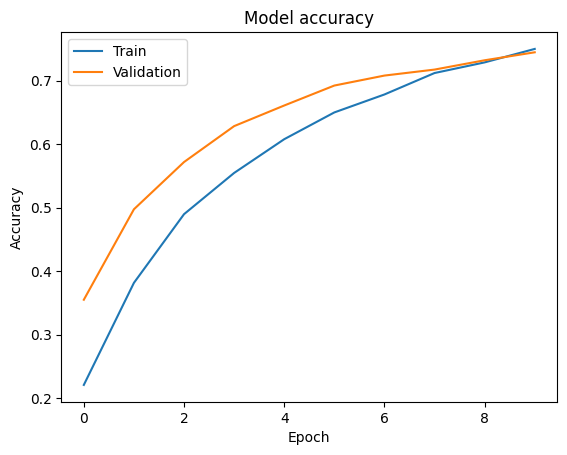

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('real_waste.png')


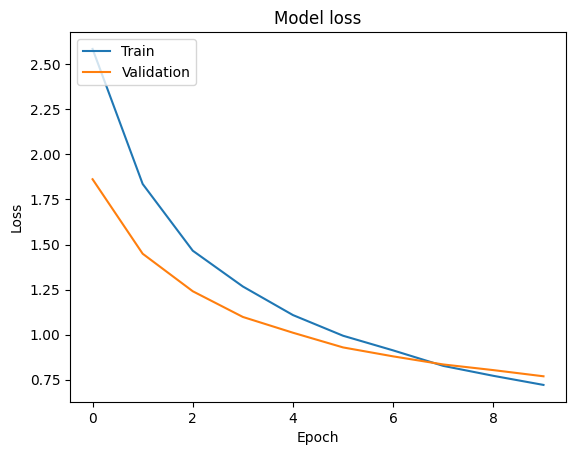

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('loss_plot.png')


In [ ]:
# y_pred = []  # store predicted labels
# y_true = []  # store true labels

# # iterate over the dataset
# for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
#    # append true labels
#    y_true.append(label_batch)
#    # compute predictions
#    preds = new_model.predict(image_batch)
#    # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))

# # convert the true and predicted labels into tensors
# correct_labels = tf.concat([item for item in y_true], axis = 0)
# predicted_labels = tf.concat([item for item in y_pred], axis = 0)

NameError: name 'model' is not defined

**DISPLAYING THE CONFUSION MATRIX AND THE ACCURACY SCORE OF THE MODEL**

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = new_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
classes=['Cardboard','Food Organics','Glass','Metal','Miscellaneous Trash','Paper','Plastic','Textile Trash','Vegetation']

cm = confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
accuracy = accuracy_score(correct_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
report = classification_report(correct_labels, predicted_labels, target_names=classes)
print('Classification Report:')
print(report)

In [ ]:
# classes=['Cardboard','Glass','Metal','Miscellaneous Trash','Organic_food','Paper','Plastic1','Textile Trash','Vegetation']

# cm = confusion_matrix(correct_labels, predicted_labels)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define classes
# classes = list(validation_generator.class_indices.keys())

# # Plot confusion matrix as heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:
# # model.save('my_transfer_learning_model.h5')
# import numpy as np

In [ ]:
# y_pred_probabilities = model.predict(validation_generator)


In [ ]:
# y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
# y_true = validation_generator.labels


In [ ]:
# y_pred_labels[42]

In [ ]:
# y_true[42]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# classes=['Cardbard','Food Organics','Glass','Metal','Miscellanous Trash','Paper','Plastic','Textile Trash','Vegetation']

# cm = confusion_matrix(y_true, y_pred_labels)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_true,y_pred_labels))
print(classification_report(y_true,y_pred_labels))